In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision import transforms
import torchvision
from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    
])

train_dataset = torchvision.datasets.VOCSegmentation('voc', year="2012",download=False, image_set="train",
                          transform=transform, target_transform=target_transform,)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=10)


In [3]:
transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    
])

test_dataset = torchvision.datasets.VOCSegmentation('/scratch/jp5881/voc', year="2012",download=False, image_set="val",
                          transform=transform, target_transform=target_transform,)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=1)

In [4]:
input_tensor = train_dataset[5][0]
input_batch = input_tensor.unsqueeze(0)

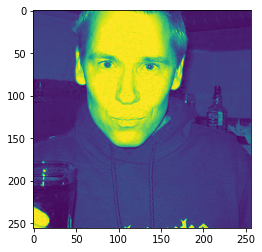

In [5]:
plt.imshow(input_tensor[0])

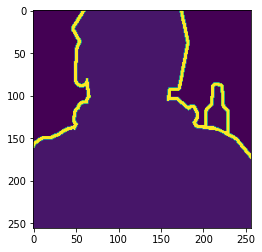

In [6]:
plt.imshow(train_dataset[5][1][0])

# **DeepLab**

In [7]:
model_t = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)
model_t.eval()
model_t.parameters()

Using cache found in /home/jp5881/.cache/torch/hub/pytorch_vision_v0.9.0


<generator object Module.parameters at 0x153bd109e890>

In [8]:
pytorch_total_params = sum(p.numel() for p in model_t.parameters())
print(pytorch_total_params/10**6)

60.996202


In [9]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model_t.to('cuda')

with torch.no_grad():
    output = model_t(input_batch)['out'][0]
print(output.shape)
output_predictions = output.argmax(0)
print(output_predictions.shape)

torch.Size([21, 256, 256])
torch.Size([256, 256])


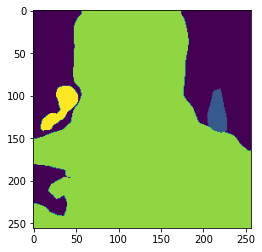

In [10]:
plt.imshow(output_predictions.cpu())

# **Unet**

In [11]:
from collections import OrderedDict


class UNet(nn.Module):

    def __init__(self, in_channels, out_channels, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [28]:
unet = UNet(in_channels=3, out_channels=21).cuda()
#unet=torch.load("final")

In [29]:
print(input_tensor.shape)
y_pred = unet(input_batch)

torch.Size([3, 256, 256])


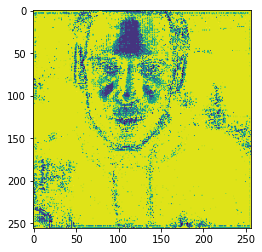

In [30]:
import numpy as np
y_pred=y_pred.detach()
output=y_pred[0]
output_predictions = torch.argmax(output,0)
plt.imshow(output_predictions.cpu())


In [31]:
model_s=unet

## Loss function for distillation

In [32]:
class CriterionPairWiseforWholeFeatAfterPool(nn.Module):
    def __init__(self, scale, feat_ind):
        '''inter pair-wise loss from inter feature maps'''
        super(CriterionPairWiseforWholeFeatAfterPool, self).__init__()
        self.criterion = sim_dis_compute
        self.feat_ind = feat_ind
        self.scale = scale

    def forward(self, preds_S, preds_T):
        feat_S = preds_S[self.feat_ind]
        feat_T = preds_T[self.feat_ind]
        feat_T.detach()

        total_w, total_h = feat_T.shape[2], feat_T.shape[3]
        patch_w, patch_h = int(total_w*self.scale), int(total_h*self.scale)
        maxpool = nn.MaxPool2d(kernel_size=(patch_w, patch_h), stride=(patch_w, patch_h), padding=0, ceil_mode=True) # change
        loss = self.criterion(maxpool(feat_S), maxpool(feat_T))
        return loss


In [33]:
class CriterionPixelWise(nn.Module):
    def __init__(self, ignore_index=255, use_weight=True, reduce=True):
        super(CriterionPixelWise, self).__init__()
        self.ignore_index = ignore_index
        self.criterion = torch.nn.CrossEntropyLoss(ignore_index=ignore_index, reduce=reduce)
        if not reduce:
            print("disabled the reduce.")

    def forward(self, preds_S, preds_T):
        preds_T[0].detach()
        N,C,W,H = preds_S.shape
        softmax_pred_T = F.softmax(preds_T.permute(0,2,3,1).contiguous().view(-1,C), dim=1)
        logsoftmax = nn.LogSoftmax(dim=1)
        loss = (torch.sum( - softmax_pred_T * logsoftmax(preds_S.permute(0,2,3,1).contiguous().view(-1,C))))/W/H
        return loss

In [38]:
loss = CriterionPixelWise()
loss1 = CriterionPairWiseforWholeFeatAfterPool
loss2 = nn.CrossEntropyLoss()
model_t.cuda()
model_s.cuda()
optimizer = optim.Adam(model_s.parameters(), lr=1e-6)
epochs=10
ll=[]
j=0
for epoch in tqdm(range(epochs)):
    model_s.train()
    model_t.eval()
    epoch_loss = 0
    j+=1
    for batch in train_loader:
        inp,out=batch
        inp,out = inp.cuda(),out.cuda()
        optimizer.zero_grad()
        output_t=model_t(inp)['out']
        output_s=model_s(inp)
        #target = torch.argmax(out, dim=1)
        loss_kd=loss(output_t,output_s)
        #loss_pa=loss1(output_t,output_s)
        target = torch.argmax(out, dim=1)
        loss_c=loss2(output_t,target)
        epoch_loss+=loss_kd+loss_c
        loss_kd.backward()
        optimizer.step()
    ll.append(epoch_loss)

  0%|          | 0/10 [00:59<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 160.00 MiB (GPU 0; 44.49 GiB total capacity; 20.27 GiB already allocated; 73.00 MiB free; 21.57 GiB reserved in total by PyTorch)

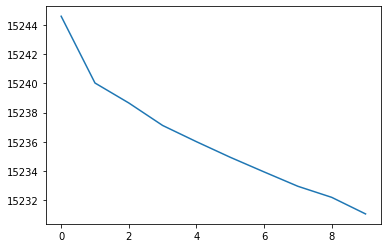

In [26]:
plt.plot(ll)

In [19]:
import torch
torch.cuda.get_device_name(0)

'Quadro RTX 8000'